# TabNet

TabNet is a deep learning architecture designed for processing tabular data. It leverages a unique sequential attention mechanism to dynamically select the most informative features. This can be achieved through a feature masking mechanism, ensuring that only relevant features are used at each decision step. Therefore, TabNet can indicate which features contribute the most to each decision step. This structured feature selection process makes TabNet  efficient and inherently interpretable. Moreover, the attention mechanism enables feature importance visualization, making it easier to understand the model’s reasoning [1]. For more details on TabNet, you can refer to [this paper](https://arxiv.org/pdf/1908.07442.pdf).

In [1]:
# installing required packages
%pip install pytorch_tabnet


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb

/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Data
In this notebook, we utilize the US-130 dataset, a structured medical dataset containing various clinical measurements collected from patients diagnosed with diabetes from 1999 to 2008. This dataset provides valuable information about patient health indicators, clinical variables, and potential risk factors associated with diabetes. These include demographic information, lab results, diabetes-related indicators, and medication history. Machine learning models can be applied to this dataset to estimate diabetes-related outcomes. e.g., hospital readmission prediction. To find more information, you can refer to [this link](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008).

In [3]:
# preprocessing function
def process_us_130_csv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function for new data downloaded from UCL
    """
    age_transform = { '[0-10)' : 5,
                      '[10-20)' : 15,
                      '[20-30)' : 25,
                      '[30-40)' : 35,
                      '[40-50)' : 45,
                      '[50-60)' : 55,
                      '[60-70)' : 65,
                      '[70-80)' : 75,
                      '[80-90)' : 85,
                      '[90-100)' : 95
                    }
    
    #Apply column specific transformations
    df['age'] = df['age'].apply(lambda x : age_transform[x])
    df['diag_1'] = df['diag_1'].apply(lambda x: x[:x.find(".")])
    df['diag_2'] = df['diag_2'].apply(lambda x: x[:x.find(".")])
    df['diag_3'] = df['diag_3'].apply(lambda x: x[:x.find(".")])
    # binarizing the target values
    df['readmitted_binarized'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0)
    # imputing missing values
    df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x: 'Unknown' if type(x) != str else x)
    df['A1Cresult'] = df['A1Cresult'].apply(lambda x: 'Unknown' if type(x) != str else x)

    #Drop columns which are not needed
    df = df.drop(['encounter_id', 'patient_nbr', 'examide',
                  'readmitted','weight','payer_code', 'medical_specialty'], axis=1)

    #Frequency encoding of categorical columns: The categorical variables are converted into numerical features by replacing each unique value in a column with its corresponding frequency in that column.
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()    
    for cat_column in categorical_columns:
        frequency_encoding = df[cat_column].value_counts(normalize=True).to_dict()
        df[f'encoded_{cat_column}'] = df[cat_column].map(frequency_encoding)
        df = df.drop(cat_column, axis=1)

    return df

In [6]:
# data loading and preparation
data = pd.read_csv("diabetic_data.csv")
df = process_us_130_csv(data)
df.index=range(df.shape[0])
df.head() # printing the first five rows of the dataset

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,encoded_tolazamide,encoded_citoglipton,encoded_insulin,encoded_glyburide-metformin,encoded_glipizide-metformin,encoded_glimepiride-pioglitazone,encoded_metformin-rosiglitazone,encoded_metformin-pioglitazone,encoded_change,encoded_diabetesMed
0,5,6,25,1,1,41,0,1,0,0,...,0.999617,1.0,0.465607,0.993063,0.999872,0.99999,0.99998,0.99999,0.538048,0.229969
1,15,1,1,7,3,59,0,18,0,0,...,0.999617,1.0,0.111196,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031
2,25,1,1,7,2,11,5,13,2,0,...,0.999617,1.0,0.465607,0.993063,0.999872,0.99999,0.99998,0.99999,0.538048,0.770031
3,35,1,1,7,2,44,1,16,0,0,...,0.999617,1.0,0.111196,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031
4,45,1,1,7,1,51,0,8,0,0,...,0.999617,1.0,0.303137,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031


### Model Training:

We apply 5-fold cross-validation, where the dataset is split into five subsets (folds). A TabNet classifier is trained on four folds while the remaining fold serves as the test set, ensuring that each fold is used for evaluation exactly once. At each iteration, the model is trained to predict the risk of readmission within 30 days of discharge. The evaluation metrics are calculated on the respective test folds, and the final performance is reported as the mean of the test results across all five folds, providing a more robust and generalized assessment of the model’s performance.

In [7]:
# https://github.com/dreamquark-ai/tabnet
X , y = df.drop("readmitted_binarized",axis=1) , df["readmitted_binarized"]
k = 5
indices = np.arange(len(X))
np.random.shuffle(indices)
folds = np.array_split(indices, k)
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i in range(k):
    test_idx = folds[i]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Use all other folds as the training set
    train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    clf = TabNetClassifier()

    clf.fit(X_train.values, y_train.values,max_epochs=20)
    y_pred = clf.predict(X_test.values)

    y_prob = clf.predict_proba(X_test.values)[:,1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test,y_pred)
    test_precision = precision_score(y_test,y_pred)
    test_recall = recall_score(y_test,y_pred)
    
    auc_scores.append(test_auc)
    f1_scores.append(test_f1)
    recall_scores.append(test_precision)
    precision_scores.append(test_recall)
    
print("mean_test_auc",np.mean(auc_scores))
print("mean_test_f1",np.mean(f1_scores))
print("mean_test_precision",np.mean(precision_scores))
print("mean_test_recall",np.mean(recall_scores))

    

/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.39412 |  0:00:06s
epoch 1  | loss: 0.3453  |  0:00:10s
epoch 2  | loss: 0.3431  |  0:00:14s
epoch 3  | loss: 0.34212 |  0:00:18s
epoch 4  | loss: 0.34135 |  0:00:22s
epoch 5  | loss: 0.34049 |  0:00:26s
epoch 6  | loss: 0.33928 |  0:00:30s
epoch 7  | loss: 0.33832 |  0:00:35s
epoch 8  | loss: 0.3384  |  0:00:38s
epoch 9  | loss: 0.33797 |  0:00:42s
epoch 10 | loss: 0.33799 |  0:00:46s
epoch 11 | loss: 0.33809 |  0:00:50s
epoch 12 | loss: 0.33759 |  0:00:55s
epoch 13 | loss: 0.33792 |  0:00:59s
epoch 14 | loss: 0.33785 |  0:01:03s
epoch 15 | loss: 0.33765 |  0:01:07s
epoch 16 | loss: 0.33767 |  0:01:11s
epoch 17 | loss: 0.33768 |  0:01:15s
epoch 18 | loss: 0.33803 |  0:01:19s
epoch 19 | loss: 0.33798 |  0:01:22s


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40134 |  0:00:03s
epoch 1  | loss: 0.35059 |  0:00:07s
epoch 2  | loss: 0.34609 |  0:00:11s
epoch 3  | loss: 0.3433  |  0:00:15s
epoch 4  | loss: 0.34286 |  0:00:19s
epoch 5  | loss: 0.3416  |  0:00:23s
epoch 6  | loss: 0.34058 |  0:00:27s
epoch 7  | loss: 0.34033 |  0:00:31s
epoch 8  | loss: 0.33922 |  0:00:35s
epoch 9  | loss: 0.33974 |  0:00:38s
epoch 10 | loss: 0.33867 |  0:00:42s
epoch 11 | loss: 0.33931 |  0:00:46s
epoch 12 | loss: 0.33836 |  0:00:50s
epoch 13 | loss: 0.33806 |  0:00:54s
epoch 14 | loss: 0.33929 |  0:00:58s
epoch 15 | loss: 0.33903 |  0:01:02s
epoch 16 | loss: 0.33899 |  0:01:06s
epoch 17 | loss: 0.33817 |  0:01:10s
epoch 18 | loss: 0.33821 |  0:01:14s
epoch 19 | loss: 0.33699 |  0:01:18s


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40017 |  0:00:03s
epoch 1  | loss: 0.34546 |  0:00:07s
epoch 2  | loss: 0.34285 |  0:00:11s
epoch 3  | loss: 0.34147 |  0:00:15s
epoch 4  | loss: 0.33928 |  0:00:19s
epoch 5  | loss: 0.33946 |  0:00:23s
epoch 6  | loss: 0.33773 |  0:00:26s
epoch 7  | loss: 0.33858 |  0:00:30s
epoch 8  | loss: 0.33794 |  0:00:34s
epoch 9  | loss: 0.33796 |  0:00:38s
epoch 10 | loss: 0.33737 |  0:00:42s
epoch 11 | loss: 0.33717 |  0:00:46s
epoch 12 | loss: 0.33708 |  0:00:50s
epoch 13 | loss: 0.33667 |  0:00:54s
epoch 14 | loss: 0.33599 |  0:00:58s
epoch 15 | loss: 0.33704 |  0:01:02s
epoch 16 | loss: 0.33788 |  0:01:06s
epoch 17 | loss: 0.33686 |  0:01:09s
epoch 18 | loss: 0.33627 |  0:01:13s
epoch 19 | loss: 0.33673 |  0:01:18s


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.39795 |  0:00:04s
epoch 1  | loss: 0.34337 |  0:00:07s
epoch 2  | loss: 0.34157 |  0:00:11s
epoch 3  | loss: 0.34014 |  0:00:15s
epoch 4  | loss: 0.33891 |  0:00:19s
epoch 5  | loss: 0.33977 |  0:00:23s
epoch 6  | loss: 0.33917 |  0:00:27s
epoch 7  | loss: 0.33885 |  0:00:31s
epoch 8  | loss: 0.33815 |  0:00:35s
epoch 9  | loss: 0.33781 |  0:00:38s
epoch 10 | loss: 0.33842 |  0:00:42s
epoch 11 | loss: 0.33753 |  0:00:46s
epoch 12 | loss: 0.33795 |  0:00:50s
epoch 13 | loss: 0.33692 |  0:00:54s
epoch 14 | loss: 0.33747 |  0:00:58s
epoch 15 | loss: 0.3363  |  0:01:02s
epoch 16 | loss: 0.33582 |  0:01:06s
epoch 17 | loss: 0.33514 |  0:01:10s
epoch 18 | loss: 0.33464 |  0:01:13s
epoch 19 | loss: 0.33476 |  0:01:17s


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40143 |  0:00:03s
epoch 1  | loss: 0.3515  |  0:00:07s
epoch 2  | loss: 0.34867 |  0:00:11s
epoch 3  | loss: 0.34698 |  0:00:15s
epoch 4  | loss: 0.34539 |  0:00:19s
epoch 5  | loss: 0.34296 |  0:00:23s
epoch 6  | loss: 0.34182 |  0:00:27s
epoch 7  | loss: 0.34099 |  0:00:30s
epoch 8  | loss: 0.33942 |  0:00:34s
epoch 9  | loss: 0.33832 |  0:00:38s
epoch 10 | loss: 0.33851 |  0:00:42s
epoch 11 | loss: 0.33845 |  0:00:46s
epoch 12 | loss: 0.33938 |  0:00:50s
epoch 13 | loss: 0.33918 |  0:00:54s
epoch 14 | loss: 0.33828 |  0:00:58s
epoch 15 | loss: 0.33769 |  0:01:01s
epoch 16 | loss: 0.3377  |  0:01:05s
epoch 17 | loss: 0.33733 |  0:01:09s
epoch 18 | loss: 0.33669 |  0:01:13s
epoch 19 | loss: 0.33744 |  0:01:17s
mean_test_auc 0.6406038046797817
mean_test_f1 0.014181496012214615
mean_test_precision 0.007233245545880576
mean_test_recall 0.44101986276634164


### Exploring Feature Importance in TabNet: Global and Local Explainability

One of the key advantages of TabNet is its inherent interpretability, which allows us to analyze the importance of different features in the model's decision-making process. In this section, we will explore feature importance scores (non-negative values) extracted from the last trained model using global and local explainability graphs, which provide insights into both overall model behavior and individual predictions.

**Global explainability** provides insights into the most influential features across the entire dataset, i.e., features determining in the model's overall decision-making process. **Local explainability** focuses on feature importance for a specific prediction, helping us understand why the model made a certain decision for the corresponding data point.





In [8]:
# global explainabilit
# extracted from https://github.com/dreamquark-ai/tabnet
# Convert feature importances to a DataFrame
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": clf.feature_importances_})

# Sort by importance values in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted values
print(importance_df)

                             Feature    Importance
25                 encoded_glipizide  1.656532e-01
42               encoded_diabetesMed  1.483709e-01
24             encoded_acetohexamide  1.034033e-01
39   encoded_metformin-rosiglitazone  1.010547e-01
9                   number_emergency  8.824343e-02
10                  number_inpatient  7.465568e-02
29             encoded_rosiglitazone  6.277416e-02
8                  number_outpatient  4.837363e-02
3                admission_source_id  3.822876e-02
33                encoded_tolazamide  2.245307e-02
18                 encoded_A1Cresult  2.127702e-02
27               encoded_tolbutamide  2.032554e-02
17             encoded_max_glu_serum  1.742806e-02
26                 encoded_glyburide  1.570489e-02
7                    num_medications  1.487658e-02
4                   time_in_hospital  1.254786e-02
22            encoded_chlorpropamide  9.874726e-03
20               encoded_repaglinide  7.820696e-03
5                 num_lab_proce

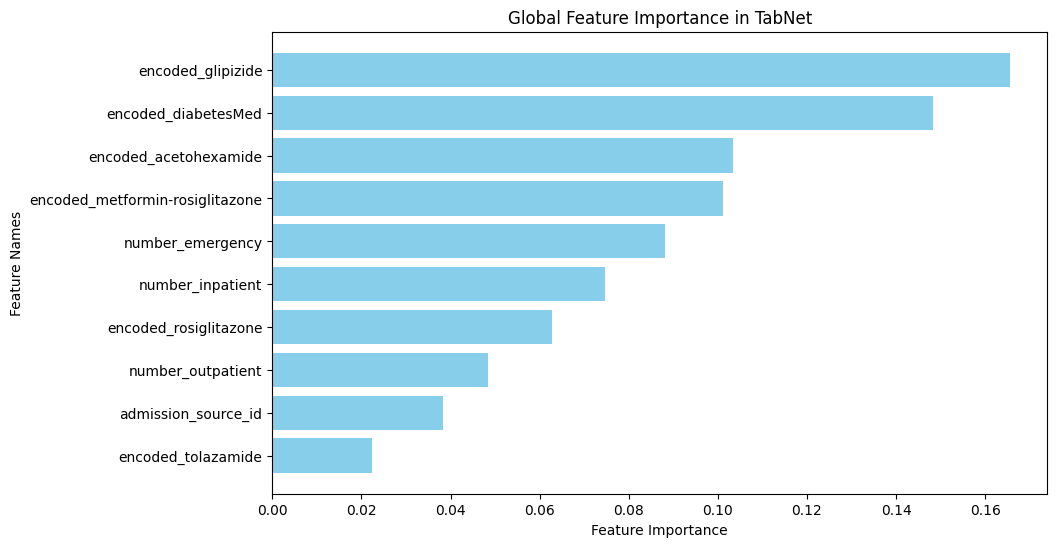

In [9]:
# Plot the most important features
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Global Feature Importance in TabNet")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
plt.show()

As can be observed **"encoded_glipizide", "encoded_diabetesMed", and "encoded_acetohexamide"** have been identified as the most important global features by TabNet. 

encoded_glipizide: Indicates whether the drug was prescribed or there was a change in the dosage. Original Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed [3]

encoded_diabetesMed: Indicates if there was any diabetic medication prescribed. Values: yes and no [3]

encoded_acetohexamide: Indicates whether the drug was prescribed or there was a change in the dosage. Original Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed [3]

In [10]:
# local explainability
# extracted from # https://github.com/dreamquark-ai/tabnet
explain_matrix, masks = clf.explain(np.array(X_test))

In [11]:
# Select an instance to visualize (e.g., first sample)
instance_idx = 0  
local_importance = explain_matrix[instance_idx]

# Create DataFrame for sorting
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": local_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted feature importance for the selected instance
print(importance_df)

                             Feature  Importance
42               encoded_diabetesMed    0.962926
10                  number_inpatient    0.959984
24             encoded_acetohexamide    0.824138
17             encoded_max_glu_serum    0.374614
33                encoded_tolazamide    0.330405
3                admission_source_id    0.245245
4                   time_in_hospital    0.000000
2           discharge_disposition_id    0.000000
1                  admission_type_id    0.000000
5                 num_lab_procedures    0.000000
0                                age    0.000000
9                   number_emergency    0.000000
8                  number_outpatient    0.000000
7                    num_medications    0.000000
6                     num_procedures    0.000000
14                    encoded_diag_1    0.000000
15                    encoded_diag_2    0.000000
13                    encoded_gender    0.000000
11                  number_diagnoses    0.000000
18                 e

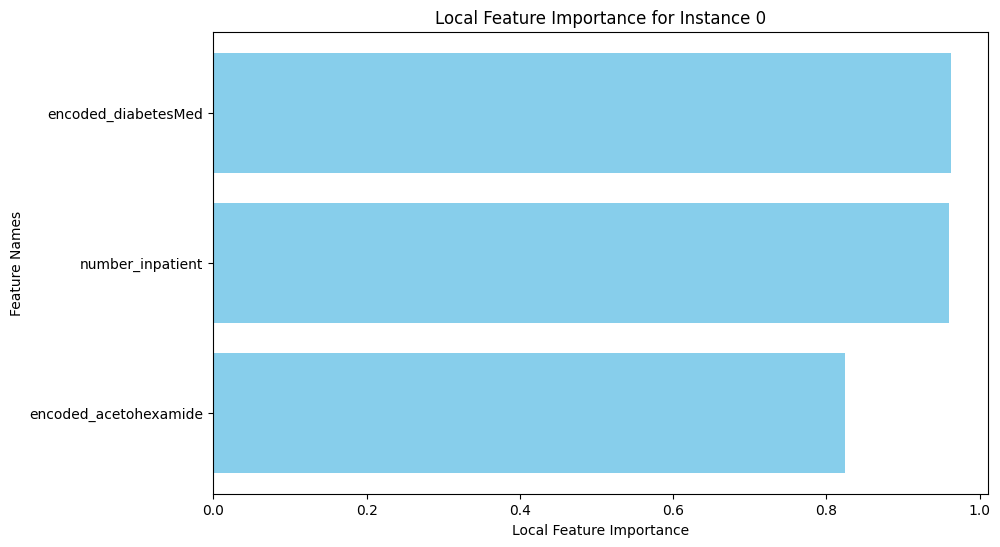

In [12]:
importance_df = importance_df.nlargest(3, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Local Feature Importance")
plt.ylabel("Feature Names")
plt.title(f"Local Feature Importance for Instance {instance_idx}")
plt.gca().invert_yaxis()  # Show most important features at the top
plt.show()

As can be observed **"encoded_diabetesMed", "number_inpatient", and "encoded_acetohexamide"** have been identified as the most important local features for the first datapoint by TabNet. 

encoded_diabetesMed: Indicates if there was any diabetic medication prescribed. Values: yes and no [3]

number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter [3]

encoded_acetohexamide: Indicates whether the drug was prescribed or there was a change in the dosage. Original Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed [3]

As an important observation, **"encoded_diabetesMed" and "encoded_acetohexamide"** apear as key features in both global and local explainability analyses. Their presence in both perspectives suggests that these features play a crucial role in the model’s decision-making process, influencing predictions at both the dataset and individual instance levels.

## Comparison with XGBoost:

Now, we will compare the performance and explainability analysis of the trained TabNet model with those of an XGBoost model trained on the same data. While XGBoost is a high-performing gradient-boosting model widely used for tabular data, it is often considered a black-box model due to its limited interpretability. In contrast, TabNet’s sequential attention mechanism provides built-in explainability, allowing us to analyze feature importance at both global and local levels. This comparison will help us evaluate the trade-off between predictive accuracy and model interpretability. 

In [14]:
X , y = df.drop("readmitted_binarized",axis=1) , df["readmitted_binarized"]
k = 5
indices = np.arange(len(X))
np.random.shuffle(indices)
folds = np.array_split(indices, k)
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i in range(k):
    test_idx = folds[i]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Use all other folds as the training set
    train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    xgb_clf = xgb.XGBClassifier()

    xgb_clf.fit(X_train.values, y_train.values)
    y_pred = xgb_clf.predict(X_test.values)

    y_prob = xgb_clf.predict_proba(X_test.values)[:,1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test,y_pred)
    test_precision = precision_score(y_test,y_pred)
    test_recall = recall_score(y_test,y_pred)
    
    auc_scores.append(test_auc)
    f1_scores.append(test_f1)
    recall_scores.append(test_precision)
    precision_scores.append(test_recall)
    
print("mean_test_auc",np.mean(auc_scores))
print("mean_test_f1",np.mean(f1_scores))
print("mean_test_precision",np.mean(precision_scores))
print("mean_test_recall",np.mean(recall_scores))

    

mean_test_auc 0.6626717534366102
mean_test_f1 0.04765026989266395
mean_test_precision 0.02518552065654245
mean_test_recall 0.4454159214542897


In [17]:
# XGB Feature Importance
# Extract feature importances from the last trained model 
importance_df = pd.DataFrame({
    "Feature": X_train.columns, 
    "Importance": xgb_clf.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)


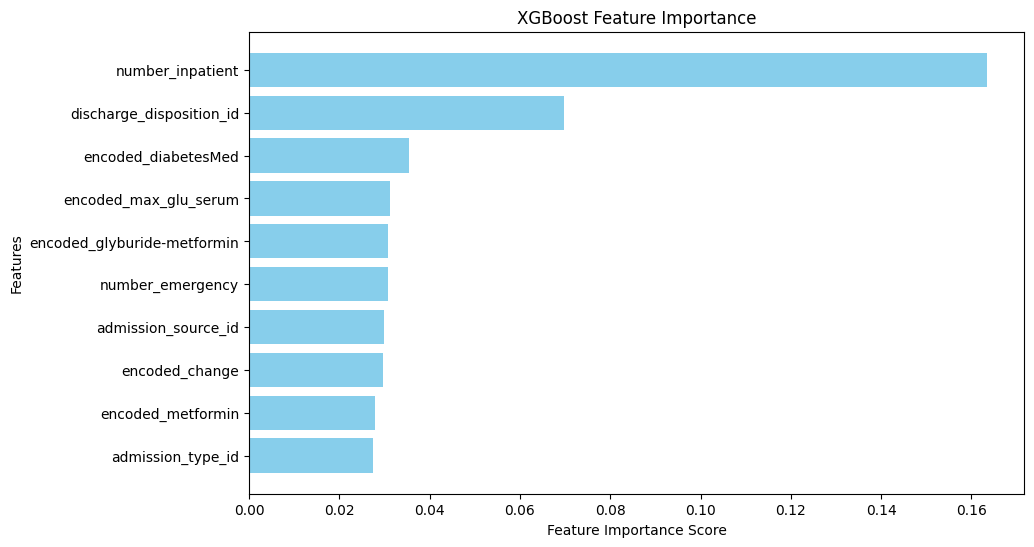

In [18]:
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

As can be observed **"number_inpatient", "discharge_disposition_id", and "encoded_diabetesMed"** have been identified as the most important features by the XGBoost model.

number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter [3]

discharge_disposition_id:Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available [3]

encoded_diabetesMed: Indicates if there was any diabetic medication prescribed. Values: yes and no [3]

As can be observed **"encoded_diabetesMed"** have been a critical feature in both TabNet and XGBoost ML model's decicion-making process, notably contributing to the 30-day readmission risk. Its high feature importance suggests that the prescription status of diabetes medication is a key factor in determining the likelihood of a patient being readmitted within this timeframe.

## References

[1] https://arxiv.org/pdf/1908.07442.pdf

[2] https://github.com/dreamquark-ai/tabnet

[3] https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008